# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging than the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well-structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at a minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

## Solution

The [kaggle page](https://www.kaggle.com/laudanum/footballdelphi) defines the tables and fields in the Sqlite file as below:

**Table: Matches**

- Match_ID (int): unique ID per match
- Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
- Season (int): Season the match took place in (usually covering the period of August till May of the following year)
- Date (str): Date of the match
- HomeTeam (str): Name of the home team
- AwayTeam (str): Name of the away team
- FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
- FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
- FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

**Table: Teams**

- Season (str): Football season for which the data is valid
- TeamName (str): Name of the team the data concerns
- KaderHome (str): Number of Players in the squad
- AvgAgeHome (str): Average age of players
- ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
- OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
- AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
- StadiumCapacity (str): Maximum stadium capacity of the team's home stadium

**Table: Unique Teams**

- TeamName (str): Name of a team
- Unique_Team_ID (int): Unique identifier for each team

**Table: Teams_in_Matches**

- Match_ID (int): Unique match ID
- Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)

We'll keep the table information in mind as we attempt to link team match information with weather data.

To start, let's import the packages and libraries that we'll be using throughout this summative lab.

In [1]:
# import necessary packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import requests
import pymongo
import json
from IPython.display import HTML

Next, let's connect to the provided SQL database and initiate a query to gather data for match dates from the Matches table for the season we're interested in, 2011.

In [2]:
# connect to SQL database 
conn = sqlite3.connect('database.sqlite')
cursor = conn.cursor()

# function to return SQL query in pandas dataframe
def sql_df(query, cursor=cursor):
    results = cursor.execute(query).fetchall()
    df = pd.DataFrame(results)
    df.columns = [i[0] for i in cursor.description]
    
    return df

# season 2011 dates query
query = '''SELECT Date FROM Matches WHERE Season=2011'''
dates_season2011 = list(set(list(sql_df(query)['Date'])))
print('Number of unique season 2011 dates:', len(dates_season2011))
print('Example dates:')
dates_season2011[0:5]

Number of unique season 2011 dates: 165
Example dates:


['2011-07-22', '2011-09-16', '2011-12-18', '2012-04-01', '2012-02-06']

There are 165 unique match dates in the 2011 season. An important item to be aware of is the date format used within the dataset. We'll need to parse the YYYY-MM-DD dates correctly when making API calls to DarkSky.

The next step is to query the SQL database for all season 2011 information from the Matches table. 

In [3]:
# season 2011 matches query 
query = '''SELECT * FROM Matches WHERE Season=2011'''
matches_df = sql_df(query)
print('Number of matches:', matches_df.shape[0])
print('Number of teams:', len(matches_df.HomeTeam.unique()))
matches_df.head()

Number of matches: 992
Number of teams: 56


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


There were 992 matches played by 56 teams in the 2011 season. 

Now that we have match information we need to obtain the weather data.
The first step of this process is to obtain a Secret Key with the Dark Sky API.

In [4]:
# secret key registered with DarkSkyAPI account
with open('../DarkSkyKey.txt', 'r') as f:
    key = f.readline()

The second step is to use object-oriented programming and build a class to pull rain status information from an API request.

In [5]:
# Class to obtain weather information from DarkSkyAPI
class WeatherGetter(object): 
    
    # initialization method with API request parameters
    def __init__(self):
        
        self.base_url = "https://api.darksky.net/forecast"
        self.secret_key = key
        self.berlin_lat = '52.5200' # from google
        self.berlin_long = '13.4050' # from google
        self.exclude = 'currently,minutely,hourly,alerts,flags' # remaining data blocks: daily  
  

    # method to make API forecast request for input YYYY-MM-DD date
    def get_date_weather(self, date_str, verbose=True):
        
        year, month, day = self.format_date(date_str)        
        date_time = "{}-{}-{}T12:00:00".format(year, month, day)
        request_url = "{}/{}/{},{},{}?exclude={}".format(self.base_url, self.secret_key, 
                                                      self.berlin_lat, self.berlin_long, date_time, self.exclude)
        response = requests.get(request_url)
        if response.status_code == 200: # OK status
            if verbose:
                print(response.status_code)
            return response
        else: # not OK status
            raise ValueError("API request error with response code {}".format(response.status_code))
          
        
    # helper function for to parse YYYY-MM-DD date string input
    def format_date(self, date_str):
        
        year = date_str[:4]
        month = date_str[5:7]
        day = date_str[8:]
        
        return year, month, day
    
    
    # method to determine if it was raining on input date
    def get_rain_status(self, response, verbose=True):
        # possible weather icons: clear-day, clear-night, rain, snow, sleet, wind, fog, cloudy, 
        # partly-cloudy-day, or partly-cloudy-night
        reply = json.loads(response.text)
        daily = reply['daily']
        data = daily['data']
        weather = data[0] 
        if 'icon' in weather: # icon is optional
            if weather['icon'] == 'rain': # rain
                if verbose:
                    print(weather['icon'])
                    
                return True
            
            else: # no rain
                if verbose:
                    print(weather['icon'])
                    
                return False
            
        else: # no icon provided so reasonably assume no rain
            
            return False
    
    
    # function to make API request and return rain status    
    def date_rain_result(self, date_str):
        
        response = self.get_date_weather(date_str, verbose=False)
        rain_status = self.get_rain_status(response, verbose=False)
        
        return rain_status
    
    
    # function to return a rain status dictionary for dates in a list
    def rain_dates_dictionary(self, dates):
        
        rain_dates = {}        
        for date in dates:
            rain_dates[date] = self.date_rain_result(date)
        
        return rain_dates

The final step in the API process is to pass the match dates into our class to determine if it was raining during that day or not (in Berlin, Germany).

In [6]:
# season 2011 API call
wg = WeatherGetter()
rain_dates = wg.rain_dates_dictionary(dates_season2011)
print('Number of dates from season 2011 matches with rain:', sum(rain_dates.values()))

Number of dates from season 2011 matches with rain: 43


We now know whether or not it was raining during the day for each date in the 2011 season. It should be noted that weather information is optional in the Dark Sky API. Where it has not been provided, we reasonably assume that it was not raining for that date. 

Our next challenge is to merge the weather information into our dataframe of matches.

In [7]:
# find matches with rain
rain_matches = []
for i in matches_df['Date']:
    if i in rain_dates.keys():
        rain_matches.append(rain_dates[i])
        
rain_matches = pd.Series(rain_matches)
matches_df['Rain'] = rain_matches
matches_df = matches_df.drop(columns=['Match_ID', 'Div', 'Season', 'Date'], axis=1)
print(matches_df.shape)
matches_df.head()

(992, 6)


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Rain
0,Nurnberg,Bayern Munich,0,1,A,True
1,Stuttgart,Bayern Munich,1,2,A,False
2,Wolfsburg,Bayern Munich,0,1,A,False
3,Mainz,Bayern Munich,3,2,H,False
4,Freiburg,Bayern Munich,0,0,D,False


Information from both of our data sources has been extracted and merged. We now have a dataframe with information on the teams, scores, result, and rain status for every season 2011 match.

The next stage in the transformation phase of our data is to compute team statistics from our match dataframe. Using object-oriented programming, let's build a class to produce team summaries.

In [8]:
# Class to obtain team statistics based on sql database and API call
class TeamStatistics:
    
    # initialization method with team information
    def __init__(self, team_name, df):
        
        self.df = df
        self.team_wld = dict()
        self.team_name = team_name
        self.home_matches = self._get_home_matches()
        self.away_matches = self._get_away_matches()          
        self.team_info = {'team': self.team_name, 
                         'goals': int(self._calc_total_goals()),
                         'wins': int(self._calc_total_wins()), 
                         'loses': int(self._calc_total_loses()),
                         'draws': int(self._calc_total_draws()),
                         'rain win %': float(self._calc_rain_wins()), 
                         'histogram': self._team_hist()}
            
    
    # method to get a team's home games
    def _get_home_matches(self):
        
        self.home_matches = self.df.loc[self.df['HomeTeam'] == self.team_name]
        
        return self.home_matches
    
    
    # method to get a team's away games
    def _get_away_matches(self):
        
        self.away_matches = self.df.loc[self.df['AwayTeam'] == self.team_name]
        
        return self.away_matches
    
    
    # method to get total team goals
    def _calc_total_goals(self):
        # FTHG (Full Time Home Goals): Number of goals scored by the home team
        # FTAG (Full Time Away Goals): Number of goals scored by the away team
        self.total_goals = self.home_matches['FTHG'].sum() + self.away_matches['FTAG'].sum()
        
        return self.total_goals
    
    
    # method to get total team wins
    def _calc_total_wins(self):
        # FTR (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)
        self.total_wins = self.home_matches['FTR'].loc[self.home_matches['FTR'] == "H"].count()+\
                          self.away_matches['FTR'].loc[self.away_matches['FTR'] == "A"].count() 
        
        return self.total_wins
    
   
    # method to get total team loses
    def _calc_total_loses(self):
        # FTR (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)
        self.total_wins = self.home_matches['FTR'].loc[self.home_matches['FTR'] == "A"].count()+\
                          self.away_matches['FTR'].loc[self.away_matches['FTR'] == "H"].count() 
        
        return self.total_wins
    
    
    # method to get total team draws
    def _calc_total_draws(self):
        # FTR (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)
        self.total_wins = self.home_matches['FTR'].loc[self.home_matches['FTR'] == "D"].count()+\
                          self.away_matches['FTR'].loc[self.away_matches['FTR'] == "D"].count() 
        
        return self.total_wins
    
    
    # method to get team's win percentage on raining days
    def _calc_rain_wins(self):
        self.home_rain = self.home_matches.loc[self.home_matches['Rain'] == True]
        self.away_rain = self.away_matches.loc[self.away_matches['Rain'] == True]
        # FTR (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)
        self.rain_wins = self.home_rain['FTR'].loc[self.home_rain['FTR'] == "H"].count()+\
                         self.away_rain['FTR'].loc[self.away_rain['FTR'] == "A"].count()            
        try:            
            self.rain_total = len(self.home_rain) + len(self.away_rain)               
            if self.rain_total != 0: # non-zero rain games
                
                return self.rain_wins / self.rain_total
            
            else: # zero rain games                
                return 0
            
        except Exception:            
            return 0
    
    
    # histogram visualization of team's wins and losses
    def _team_hist(self):
        
        self.path = f'histograms/{self.team_name}.png'       
        with open(self.path, 'wb') as f:            
            self.team_wld = {'wins':self._calc_total_wins(),
                             'loses':self._calc_total_loses(),
                             'draws':self._calc_total_draws()}
            
            self.chart = plt.bar(range(len(self.team_wld.values())), self.team_wld.values(), 
                                 tick_label=['wins','loses','draws'], color=['g','r','b'])
            plt.title(f'{self.team_name} team histogram')
            plt.savefig(self.path, transparent=True)            
            self.img_path = '<img src="{}"/>'.format(self.path)
            
            return self.img_path

Let's use the team statistics class to find the total goals, wins, loses, draws, win percentage for rain matches, and visualizations for each team.

Example histogram visualization:


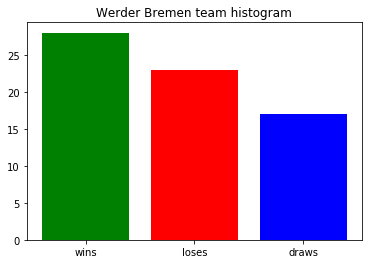

In [9]:
# obtain statistics for each team in the database
teams = list(set(matches_df['HomeTeam']))
all_team_stats = []
for team in teams:
    team_stats = TeamStatistics(team, matches_df)
    all_team_stats.append(team_stats)

print('Example histogram visualization:')

Our dataset has been fully transformed. Now let's load it into a MongoDB instance.

In [10]:
# create MongoDB connection
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/") # instance : host : port
myclient.drop_database("mod2_project_db")
mydb = myclient["mod2_project_db"]
mycol = mydb['football_delphi_team_stats']

# add team statistics to collection
for t in all_team_stats:
    add_team = mycol.insert_one(t.team_info)
print('MongoDB databases:', myclient.list_database_names())
print('mod2_project_db collections:', mydb.list_collection_names())

MongoDB databases: ['admin', 'config', 'lab_db', 'local', 'mod2_project_db', 'test']
mod2_project_db collections: ['football_delphi_team_stats']


Above we confirm that the MongoDB database created by our client exists and that the collection where we loaded our football (soccer) team statistics also exists.

For our final step, let's review the information we placed in our MongoDB collection to find the following:

1. Name of the team.
2. Total number of goals scored by the team in 2011 season.
3. Total number of wins earned by the team in 2011 season.
4. Histogram visualization of the team's wins and losses in the 2011 season.
5. Team's win percentage on days where it was raining in the 2011 season.

In [11]:
# query MongoDB for team stats
team_results = []
query = mycol.find({})
for q in query:
    team_results.append(q)

# display final results
result_df = pd.DataFrame(team_results)
result_df = result_df[['_id', 'team', 'goals', 'wins', 'loses', 'draws', 'rain win %', 'histogram']]
result_df.drop('_id', axis=1, inplace=True)
HTML(result_df.to_html(escape=False))

,team,goals,wins,loses,draws,rain win %,histogram
0,Dortmund,80,25,3,6,0.714286,
1,Braunschweig,37,10,9,15,0.666667,
2,Fulham,48,14,14,10,0.444444,
3,Nurnberg,38,12,16,6,0.666667,
4,Freiburg,45,10,14,10,0.166667,
5,Man United,89,28,5,5,0.818182,
6,Union Berlin,55,14,14,6,0.444444,
7,Paderborn,51,17,7,10,0.375000,
8,St Pauli,59,18,8,8,0.777778,
9,Wolfsburg,47,13,16,5,0.500000,


Success! The objectives of this lab have been completed.

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!